<a href="https://colab.research.google.com/github/antonKornilov1/some/blob/architecture1/Lenet_mnist_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [153]:
import torchvision.datasets

In [154]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [155]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

In [156]:
len(y_train), len(y_test)

(60000, 10000)

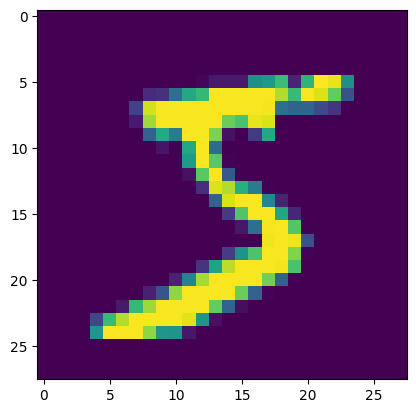

tensor(5)


In [157]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [158]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [159]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [160]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

lenet5 = LeNet5()

In [161]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [162]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []
train_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(25):
    order = np.random.permutation(len(X_train))
    epoch_train_loss = 0
    batch_count = 0

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = lenet5.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

        epoch_train_loss += loss_value.item()
        batch_count += 1

    train_loss_history.append(epoch_train_loss / batch_count)
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(accuracy)

tensor(0.9704)
tensor(0.9839)
tensor(0.9857)
tensor(0.9826)
tensor(0.9872)
tensor(0.9847)


In [ ]:
lenet5.forward(X_test)

In [ ]:
plt.plot(test_accuracy_history);

In [ ]:
plt.plot(test_loss_history);

In [ ]:
test_accuracy_history = [float(x) for x in test_accuracy_history]
test_loss_history = [float(x) for x in test_loss_history]

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss', alpha=0.7)
plt.plot(test_loss_history, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()